# 1. Install Required Libraries


In [1]:
!pip install hmmlearn yfinance tensorflow numpy pandas scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.3 MB/s eta 0:00:00


# 2. Load Stock Data using yfinance


In [2]:
import yfinance as yf
import pandas as pd

# Download stock data (AAPL - Apple Inc.)
data = yf.download('AAPL', start='2010-01-01', end='2022-01-01')

# Display the first few rows of the dataset
print(data.head())


[*********************100%***********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.454505  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.465664  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.362820  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.351058  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.393280  447610800


# 3. Preprocess the Data


In [14]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the data for better training performance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences (past 60 days of data)
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(seq_length, len(data)):
        sequences.append(data[i-seq_length:i])
        labels.append(data[i][3])  # Using the 'Close' price as the label
    return np.array(sequences), np.array(labels)

# Define sequence length (60 days of stock data)
seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets (80% training, 20% testing)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# 4. Step 1: Hidden Markov Model (HMM)


In [15]:
from hmmlearn import hmm

# Define and train HMM model on 'Close' price data
hmm_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)

# Fit HMM on training 'Close' prices
close_prices_train = X_train[:, :, 3]  # Select only 'Close' prices for HMM
close_prices_train = close_prices_train.reshape(-1, 1)  # Reshape for HMM fitting
hmm_model.fit(close_prices_train)

# Predict hidden states for training and test data
hidden_states_train = hmm_model.predict(close_prices_train)

# Predict hidden states for test data
close_prices_test = X_test[:, :, 3]  # Select only 'Close' prices for HMM
close_prices_test = close_prices_test.reshape(-1, 1)
hidden_states_test = hmm_model.predict(close_prices_test)


# 5. Step 2: LSTM Model for Stock Price Prediction


In [16]:
# Reshape hidden states to match sequence lengths for LSTM
hidden_states_train_reshaped = hidden_states_train.reshape(-1, seq_length, 1)
hidden_states_test_reshaped = hidden_states_test.reshape(-1, seq_length, 1)

# Concatenate hidden states to the original features
X_train_combined = np.concatenate([X_train, hidden_states_train_reshaped], axis=-1)
X_test_combined = np.concatenate([X_test, hidden_states_test_reshaped], axis=-1)

print(X_train_combined.shape)  # Should now have an additional feature dimension


(2368, 60, 5)


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_combined.shape[1], X_train_combined.shape[2])))
model.add(LSTM(50, return_sequences=False))

# Output layer (predict the 'Close' price)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train_combined, y_train, epochs=20, batch_size=64)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0052
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0362e-04
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0472e-05
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9867e-05
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5026e-05
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3852e-05
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4291e-05
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3304e-05
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4631e-05
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8333e-05
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9467e-05
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7842e-05
Epoch 13/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0321e-05
Epoch 14/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5757e-05
Epoch 15/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7

# 6. Step 3: Combine HMM with LSTM


In [9]:
# Append the hidden states as a new feature for LSTM
hidden_states_train_reshaped = hidden_states_train.reshape(X_train.shape[0], 1, 1)  # Reshape to (samples, 1, 1)
hidden_states_test_reshaped = hidden_states_test.reshape(X_test.shape[0], 1, 1)  # Reshape to (samples, 1, 1)

# Use broadcasting to expand the hidden states to match the timesteps dimension
hidden_states_train_expanded = np.repeat(hidden_states_train_reshaped, X_train.shape[1], axis=1)
hidden_states_test_expanded = np.repeat(hidden_states_test_reshaped, X_test.shape[1], axis=1)

X_train_combined = np.concatenate((X_train, hidden_states_train_expanded), axis=2)  # Concatenate along the features axis
X_test_combined = np.concatenate((X_test, hidden_states_test_expanded), axis=2)  # Concatenate along the features axis

# Train LSTM again with combined features (price + hidden states)
model.fit(X_train_combined, y_train, epochs=20, batch_size=64)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0045
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0829
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1974e-04
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2291e-04
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0971e-04
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0653e-05
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1736e-04
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1750e-04
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4932e-04
Epoch 13/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3821e-04
Epoch 14/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.6109e-05
Epoch 15/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

# 7. Step 4: Evaluate the Model


In [13]:
# Predict stock prices on test data
predicted_prices = model.predict(X_test_combined)

# Inverse transform to get the actual price values
predicted_prices = scaler.inverse_transform(np.concatenate([X_test[:, :, :3], predicted_prices.reshape(-1, 1)], axis=1))[:, -1]

# Plot the actual vs predicted prices
import matplotlib.pyplot as plt

plt.plot(data.index[-len(predicted_prices):], scaler.inverse_transform(scaled_data[-len(predicted_prices):])[:, 3], label="Actual")
plt.plot(data.index[-len(predicted_prices):], predicted_prices, label="Predicted")
plt.legend()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


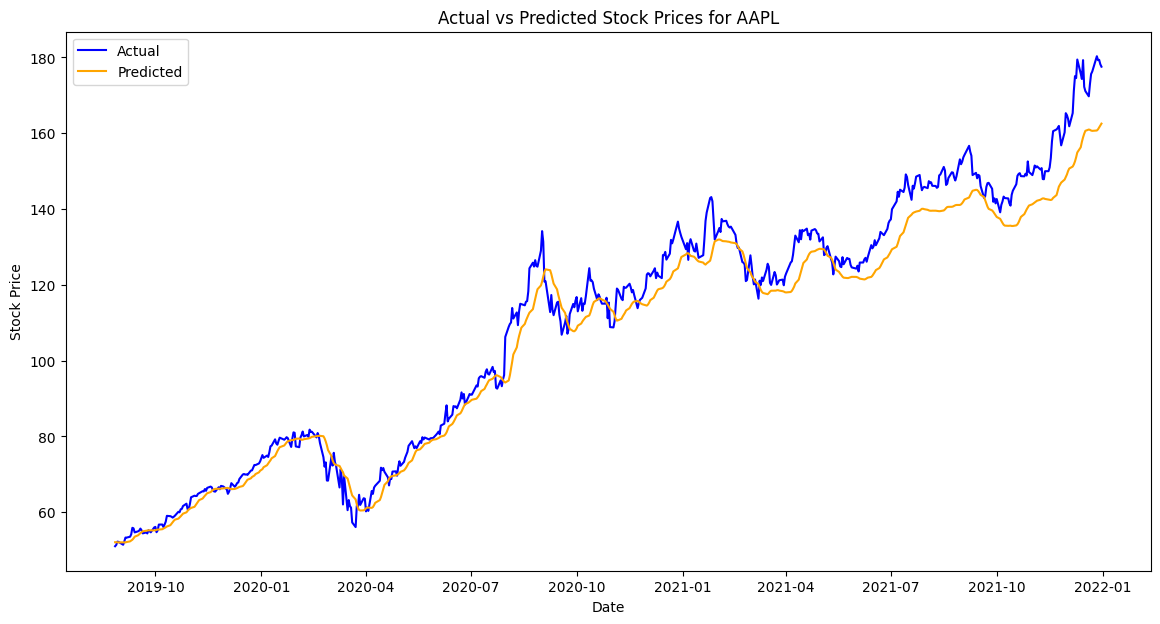

In [22]:
# Predict stock prices on test data
predicted_prices = model.predict(X_test_combined)

# Inverse transform to get the actual price values
# Correctly reshape and concatenate for inverse scaling
predicted_prices_rescaled = scaler.inverse_transform(
    np.concatenate([X_test[:, -1, :3], predicted_prices.reshape(-1, 1)], axis=1)
)[:, -1]

# Step 9: Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(predicted_prices_rescaled):], scaler.inverse_transform(scaled_data[-len(predicted_prices_rescaled):])[:, 3], label="Actual", color='blue')
plt.plot(data.index[-len(predicted_prices_rescaled):], predicted_prices_rescaled, label="Predicted", color='orange')
plt.title(f"Actual vs Predicted Stock Prices for {stock_symbol}")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


Sample data:
                Open      High       Low     Close
Date                                              
2010-01-04  7.622500  7.660714  7.585000  7.643214
2010-01-05  7.664286  7.699643  7.616071  7.656429
2010-01-06  7.656429  7.686786  7.526786  7.534643
2010-01-07  7.562500  7.571429  7.466071  7.520714
2010-01-08  7.510714  7.571429  7.466429  7.570714
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0068
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9772e-04
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2273e-05
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9650e-05
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1448e-05
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8009e-05
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5493e-05
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9670e-05
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7274e-05
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7633e-05
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5401e-05
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6464e-05
Epoch 13/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5245e-05
Epoch 14/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5524e-05
Epoch 15/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6

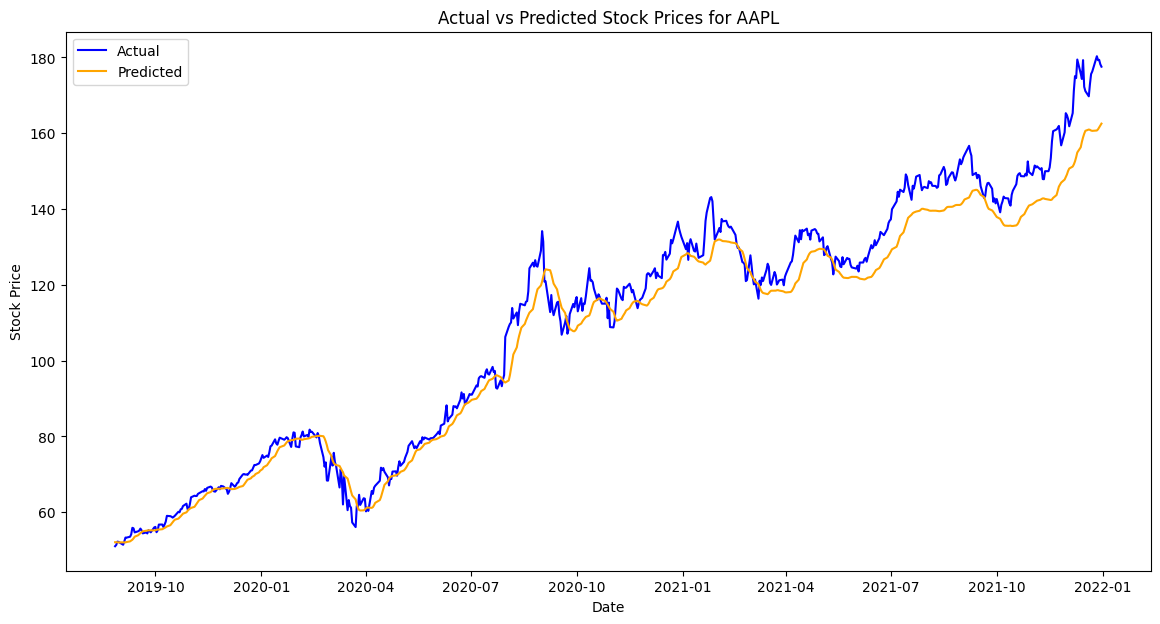

In [21]:
# Step 1: Install necessary libraries
# !pip install hmmlearn yfinance tensorflow numpy pandas scikit-learn matplotlib

# Step 2: Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Step 3: Fetch stock data
stock_symbol = 'AAPL'  # Apple Inc. stock
data = yf.download(stock_symbol, start='2010-01-01', end='2022-01-01')

# Select the features (Open, High, Low, Close)
data = data[['Open', 'High', 'Low', 'Close']]
print("Sample data:")
print(data.head())

# Step 4: Preprocess data (scaling and creating sequences)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(seq_length, len(data)):
        sequences.append(data[i-seq_length:i])
        labels.append(data[i, 3])  # Predict the 'Close' price
    return np.array(sequences), np.array(labels)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 5: Train the Hidden Markov Model (HMM)
close_prices_train = X_train[:, :, 3].reshape(-1, 1)  # 'Close' price as input for HMM
hmm_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
hmm_model.fit(close_prices_train)

# Predict hidden states for training and testing sets
hidden_states_train = hmm_model.predict(close_prices_train).reshape(-1, seq_length, 1)
close_prices_test = X_test[:, :, 3].reshape(-1, 1)  # 'Close' price as input for HMM (test set)
hidden_states_test = hmm_model.predict(close_prices_test).reshape(-1, seq_length, 1)

# Step 6: Combine hidden states with original features for LSTM
X_train_combined = np.concatenate([X_train, hidden_states_train], axis=-1)
X_test_combined = np.concatenate([X_test, hidden_states_test], axis=-1)

# Step 7: Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_combined.shape[1], X_train_combined.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))  # Output layer (predict 'Close' price)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train_combined, y_train, epochs=20, batch_size=64)

# Step 8: Evaluate and predict stock prices on the test set
predicted_prices = model.predict(X_test_combined)


